<a href="https://colab.research.google.com/github/silviazandoli/explanaible_ai/blob/master/5_Fifa_2018_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

Chapter 4 - Model Agnostic Methods-SHAP

gianfagna_l_di_cecco_a_explainable_ai_with_python (Book)

In [3]:
#download dataset here
#https://www.kaggle.com/datasets/mathan/fifa-2018-match-statistics
fifa = pd.read_csv('FIFA 2018 Statistics.csv')
fifa

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,11-07-2018,England,Croatia,1,46,11,1,6,4,4,...,1,0,0,No,5.0,Semi- Finals,No,0,NaN,NaN
124,14-07-2018,Belgium,England,2,43,12,4,3,5,4,...,1,0,0,Yes,4.0,3rd Place,No,0,NaN,NaN
125,14-07-2018,England,Belgium,0,57,15,5,7,3,5,...,2,0,0,No,NaN,3rd Place,No,0,NaN,NaN
126,15-07-2018,France,Croatia,4,39,8,6,1,1,2,...,2,0,0,Yes,18.0,Final,No,0,1.0,18.0


In [4]:
y = (fifa['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in fifa.columns if fifa[i].dtype in [np.int64]]
X = fifa[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100, random_state=0).fit(train_X, train_y)

#select match Uruguay-Russia
row_to_show = 19
data_for_prediction = val_X.iloc[row_to_show] #A
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
#see the prediction from our ML Random Forest model of having Uruguay assigned the “Man of The Match” award (52%):
"""
to remember
predict() is used to predict the actual class (in your case one of 0, 1, or 2).
predict_proba() is used to predict the class probabilities
"""
my_model.predict_proba(data_for_prediction_array)
#A use 1 row of data here. Could use multiple rows if desired


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.48, 0.52]])

In [5]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.5 MB/s eta 0:00:00


In [6]:
import shap #A
k_explainer = shap.KernelExplainer(my_model.predict_proba,
train_X) #B
k_shap_values = k_explainer.shap_values(data_for_prediction)
#A package used to calculate Shap values
#B # use KernelSHAP to explain test set predictions
shap.initjs() #da mettere per visualizzare il grafico
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


SHAP diagram that shows how the features impact on the match Uruguay-Russia. A
force diagram representing how much the features change the final value. For example we see that
“Goal Scored = 3” has the most impact for it pushes the final value to the right with the biggest
interval.

Features on the left are the
ones that increase the predictions, and their relative length is an indication of the
importance of the features in determining the prediction.
Features on the right, same logic, are the ones that are expected to decrease the
prediction value. For this specific match, we predicted a probability of 0.52 for
Uruguay to have “Player of the Match” that is not so high considering that they
scored three goals (remember that goal scored was identified as the most important
feature).
The value 0.52 has to be compared with the baseline value of 0.50, which is the
average of all the outputs and, in this case, represents the maximal uncertainty. We
see the explanation of this result: albeit the red driving features, we have the free
kicks, attempts, and off-target features that depress the overall probability. The shift
from the baseline is the difference in length between the sum of red bars and the
blue bars.

SHAP allows getting a summary plot in which we see the
impact of each feature on each prediction.

  0%|          | 0/32 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


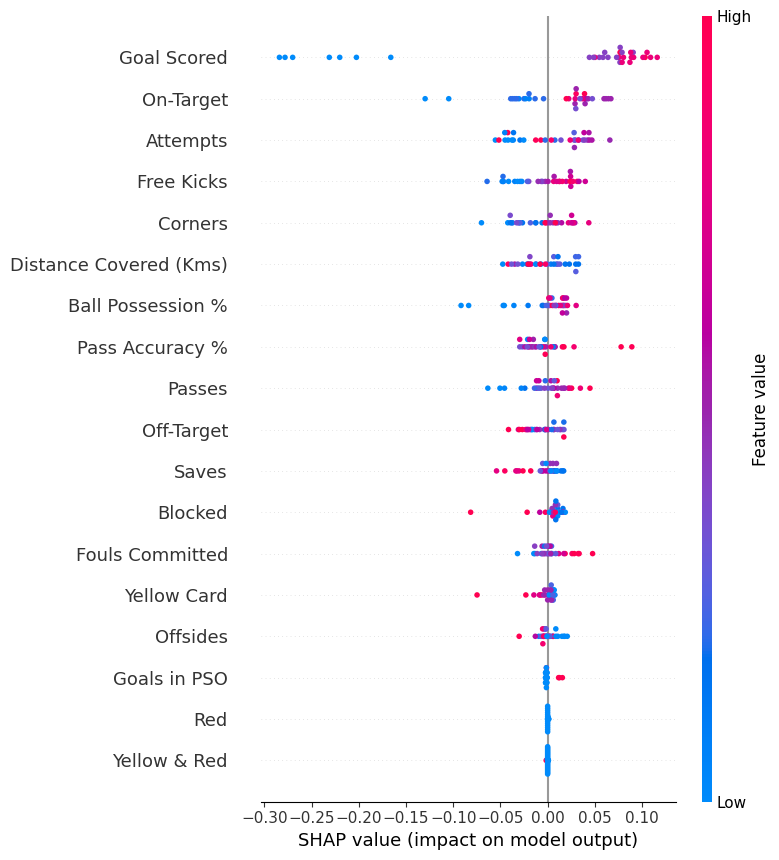

In [7]:
shap_values = k_explainer.shap_values(val_X) #A
shap.summary_plot(shap_values[1], val_X)
#A We call the summary plot

SHAP allows getting a summary plot in which we see the
impact of each feature on each prediction.

Recap

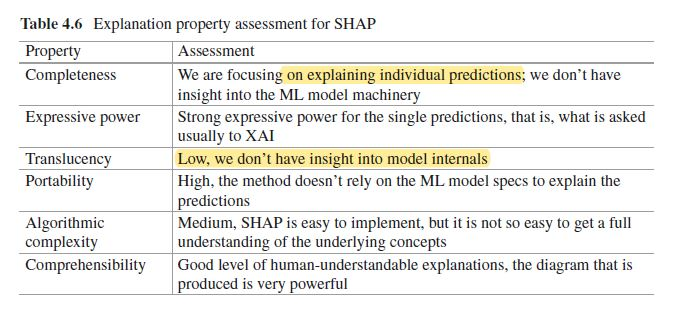